# Productionization

This notebook is based on fastai's **[Chapter 2](https://github.com/fastai/fastbook/blob/master/02_production.ipynb)**.

Please read that chapter before looking at this review.

*I suggest opening this notebook in Colab (where it can be easier to use GPU).*
*If you want to run it locally, set up the **deep-learning** environment in your terminal with `conda env create -f environment.yml` and activate it in your preferred IDE.*

In [1]:
### FOR COLAB USERS ###
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.7 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
# ### FOR LOCAL USERS ###
# import fastai
# print(fastai.__version__)

# ! pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

# Image downloading
Note: this was sort of a nightmare. I had to create an Azure account and use those creds to get this image. Other fastai users have mentioned other ways of getting the images. You can use the **[forum](https://forums.fast.ai/t/lesson-2-official-topic/96033)** to help if you are having trouble with this.

In [ ]:
# download grizzly bear URLs
# secret = <your secret key>
key = os.environ.get('AZURE_SEARCH_KEY', secret)
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

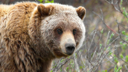

In [ ]:
# test one
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
# download images for the 3 types of bears
bear_types = 'grizzly','black','teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()

for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} bear')
    download_images(dest, urls=results.attrgot('contentUrl'))


In [ ]:
# get image file names -- aka check to make sure they downloaded
fns = get_image_files(path)
len(fns), fns[0:3]

(433,
 (#3) [Path('bears/teddy/f73043b8-690f-45c9-8e1f-cecaa957d25d.jpg'),Path('bears/teddy/213dfbda-cf87-474d-b9e2-3b43aad9a4ed.jpg'),Path('bears/teddy/146da34e-84b8-49a9-adbf-d4642de76a02.jpg')])

In [ ]:
# see which images failed to download (corrupt)
failed = verify_images(fns)
len(failed), failed[0:2]

(3,
 (#2) [Path('bears/grizzly/d7ee6ac5-cdcf-4143-a0dd-b352e649c008.jpg'),Path('bears/grizzly/c71162b4-ec2c-4db8-a81f-cd4d2ac1716c.jpg')])

In [ ]:
# remove failed images
failed.map(Path.unlink);

# DataLoaders (fastai class)
Understanding DataLoader vs DataLoaders is important, but a bit confusing.
- **DataLoader**: providers batches to the GPU.
- **DataLoaders**: class that stores DataLoader objects and lets you access the train / valid sets.

In [ ]:
# telling the program what our data looks like
bears = DataBlock(
    blocks=(
        ImageBlock, # independent variable type (images of bears)
        CategoryBlock # dependent variable type (category of bear)
        ),
    get_items=get_image_files, # how to get the images (fastai function)
    splitter=RandomSplitter(
        valid_pct=0.2,
        seed=42
        ), # how to get the validation set (here it is random, but could be from a csv or folder names, etc)
    get_y=parent_label, # how to get the labels (y) (fastai function to get folder names)
    item_tfms=Resize(128) # transforming images to the same size
    )

# actually loading the data
dls = bears.dataloaders(path)

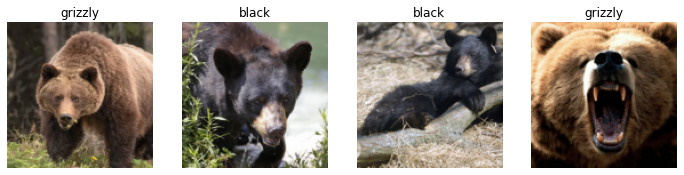

In [ ]:
# show a batch
# the resizing was done by cropping
dls.valid.show_batch(max_n=4, nrows=1)

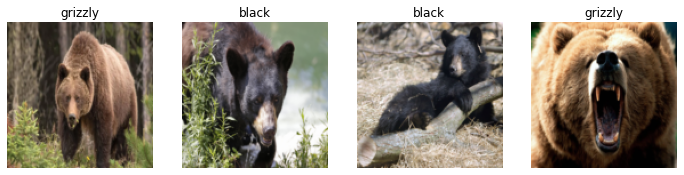

In [ ]:
# change the resizing by squishing instead of cropping

# update the DataLoader
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))

# load the data
dls = bears.dataloaders(path)

# show the batch
dls.valid.show_batch(max_n=4, nrows=1)

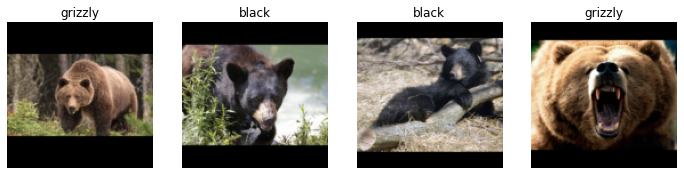

In [ ]:
# change the resizing by adding black (padding with 0s) inatead of cropping or squishing
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

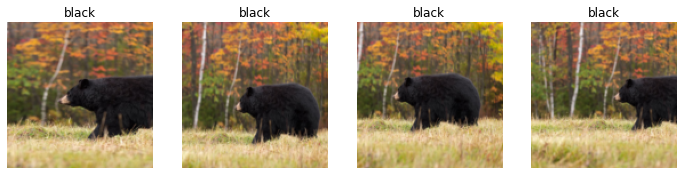

In [ ]:
# better: instead of padding or cropping or squishing -- randomly select a part of the image
bears = bears.new(item_tfms=RandomResizedCrop(
    128,
    min_scale=0.3 # min_scale: how much of the image to select at minimum each time
    ))
dls = bears.dataloaders(path)
dls.train.show_batch(
    max_n=4,
    nrows=1,
    unique=True # have the same image repeated with different versions of this RandomResizedCrop transform
    )


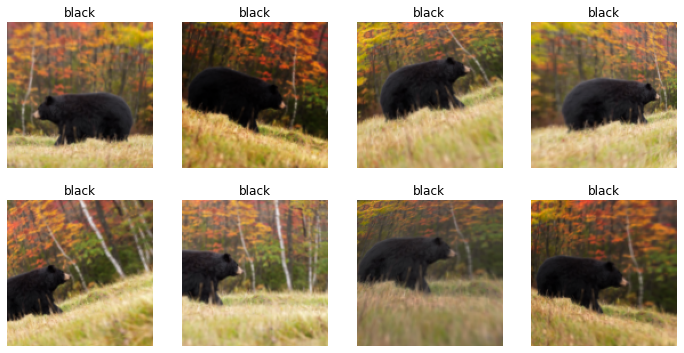

In [ ]:
# even better: data augmentation (e.g., rotation, flipping, constrast changes)
bears = bears.new(
    item_tfms=Resize(128), # not using RandomResizedCrop for visualization purposes
    batch_tfms=aug_transforms(
        mult=2 # standard set of augmentations
        ) # do these transformations on a batch
    )
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training the CNN Model

In [ ]:
# create dataloaders
bears = bears.new(
    item_tfms=RandomResizedCrop(
        224, # this is a standard size for image classification
        min_scale=0.5
        ),
    batch_tfms=aug_transforms()) # default
dls = bears.dataloaders(path)

In [ ]:
# create the learner
learn = vision_learner(
    dls, # data source, as we saw above
    resnet18, # the pretrained resnet model (18 layers)
    metrics=error_rate
    )

# fine tune (since it is a pre-trained model)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

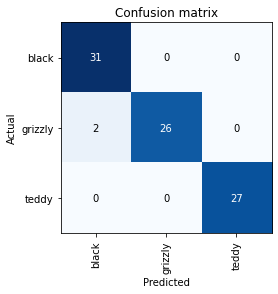

In [ ]:
# interpretation -- which classes are being confused
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

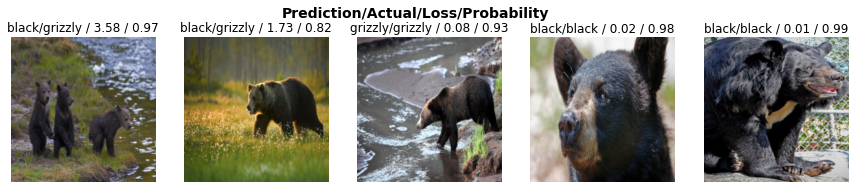

In [ ]:
# where are the errors occuring? Sort images by their loss
interp.plot_top_losses(5, nrows=1)

In [ ]:
# fastai GUI for viewing the highest loss images and finds their indices
# so you option to re-label or remove them (but have to do manually)
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# unlink (remove/delete) images from the dataset
for idx in cleaner.delete():
  cleaner.fns[idx].unlink()

# change label
for idx,cat in cleaner.change():
  shutil.move(str(cleaner.fns[idx]), path/cat)

# Inference / Prediction
Need to save the model (export the architecture / parameters) to use it in production.

In [ ]:
# export pickle file (of model)
learn.export()

# check to see it exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
# load the learner
learn_inf = load_learner(path/'export.pkl')

In [ ]:
# upload test image
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)
im = Image.open(dest)

In [ ]:
# predict class of test bear image
# returns: (1) predicted category, (2) index of predicted category, (3) probs of each category
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([3.8489e-07, 1.0000e+00, 1.9077e-08]))

In [ ]:
# check which categories are which in the DataLoader
# index of 'grizzly' is 1
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

# Turning Model into an App
This is using IPython widgets and Voila (which makes widgets available to end users)

In [ ]:
# uplaod image
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
# get image
img = PILImage.create(btn_upload.data[-1])

In [ ]:
# view image
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:
  display(
      img.to_thumb(128,128)
      )
out_pl

Output()

In [ ]:
# get prediction
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
# display predicted labels
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.9914')

In [ ]:
# turn the above steps into a button
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
# define function (uses the above steps)
def on_click_classify(change):
    img = PILImage.create(
        btn_upload.data[-1]
        )
    out_pl.clear_output()
    with out_pl:
      display(
          img.to_thumb(
              128,128
              )
          )
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
# Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Notebook into real app
This is done outside of this jupyter notebook.

1. Start a new notebook and add code to get widgets
```
!pip install voila
!jupyter serverextension enable --sys-prefix voila
```

2. Look at the `bear_classifier` notebook in the repo
3. Use **[binder](https://mybinder.org/)** to host. FastAI's instructions on this:
- Add your notebook to a GitHub repository.
- Paste the URL of that repo into Binder's URL, as shown in <>.
- Change the File dropdown to instead select URL.
- In the "URL to open" field, enter /voila/render/name.ipynb (replacing name with the name of for your notebook).
- Click the clickboard button at the bottom right to copy the URL and paste it somewhere safe.
- Click Launch.